# Algorithm
1. initialize k = some constant, `k`: **no. of clusters** the points will be clustered in
2. select k random points from the sample: `cluster_centroids`.
3. for each point of the data set
    1. find distance with all points in `cluster_centroids`
    2. assign point to the closest cluster_centroid
4. recalculate `cluster_centroids` using mean of all points of each cluster
5. convergence
    1. `cluster_centroids` remain same
    2. cluster no. of no point changes

In [8]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random
import numpy as np

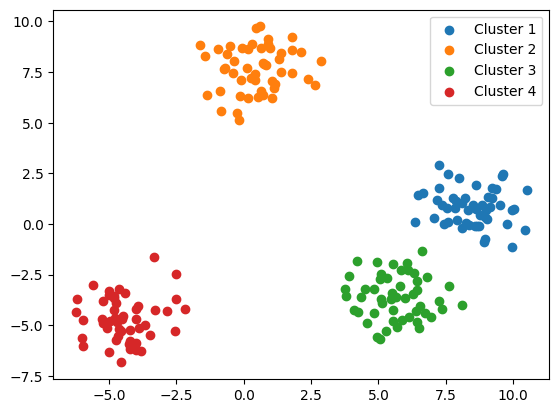

In [18]:
# 2-d clusters 
X, y = make_blobs(n_samples=200, centers=4)

for cluster_index in (list(set(y))):
    plt.scatter(X[y == cluster_index, 0], X[y == cluster_index, 1], label=f'Cluster {cluster_index+1}')
plt.legend()
plt.show()

In [27]:
n_iter = 100
n_clusters = 4
cluster_centroids = X[np.random.randint(0, X.shape[0], size=n_clusters), :] # initial centroid initialisation
final_clusters = None
for _ in tqdm(range(n_iter), "Iterating through K-Means Clustering..."):
    clusters = [[] for _ in range(n_clusters)]
    for pt_idx in range(X.shape[0]):
        # try assigning each point to a cluster
        distances = []
        for c in cluster_centroids:
            # find euclidean distance of point pt_idx from each cluster_centroid
            distances.append(
                np.sum((X[pt_idx, :] - c)**2)
            )
        distances = np.array(distances)
        clusters[np.argmin(distances)].append(pt_idx)
    new_centroids = [
        np.mean(X[np.array(cluster_i), :], axis=0)
        for cluster_i in clusters
    ]
    # TODO: Actual convergence
    # if new_centroids == cluster_centroids:
    #     print(f"Found convergence!!")
    #     break
    # print(new_centroids, "\n\n", cluster_centroids, "\n\n", clusters)
    cluster_centroids = new_centroids
    final_clusters = clusters
    # break



Iterating through K-Means Clustering...:   0%|          | 0/100 [00:00<?, ?it/s]

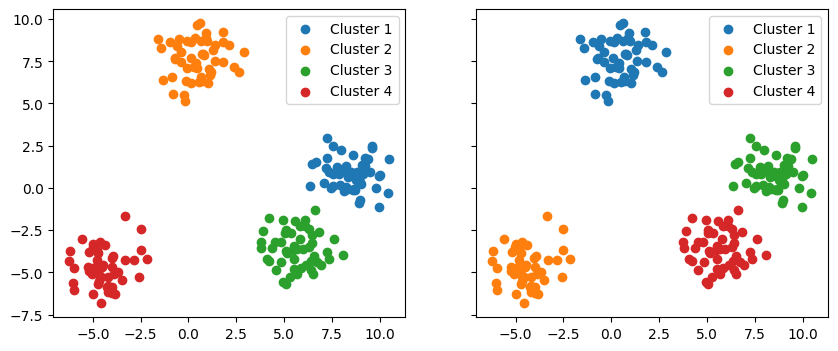

In [28]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize=(10, 4))

for cluster_index in (list(set(y))):
    ax[0].scatter(X[y == cluster_index, 0], X[y == cluster_index, 1], label=f'Cluster {cluster_index+1}')

for cluster_index, cluster_points in enumerate(final_clusters):
    ax[1].scatter(X[cluster_points, 0], X[cluster_points, 1], label=f'Cluster {cluster_index+1}')

ax[0].legend();ax[1].legend()
plt.show()

# Elbow-method to choose the optimal `k` value
5. **Mathematical Intuition**

# Problems with K-Means Clustering
- elbow method expensive when dataset size is large <font color="red">validate this!!</font>
- outliers may not be handled well
    - <font color="red">should outliers be categorised to the *nearest* cluster, or should they be assigned a separate cluster?</font>
- clusters of different orientation may not be captured